# The Weibull-Nycander-Gold Distribution

## 📖 Introduction

A [living polymerization] (LP) is a particular type of chain-growth polymerization in which the number of polymer chains remains constant. In practice, this means that the only reactions considered are initiation and propagation, while termination and transfer reactions are negligible. In this case, the reaction scheme can be written as follows:

\begin{align*}
I + M   &\xrightarrow{k_i} P_1 \\
P_n + M &\xrightarrow{k_p} P_{n+1}
\end{align*}

Assuming that both the initiation and propagation steps are first-order with respect to the monomer and the active center, the transient species balances are:

\begin{align}
\frac{\mathrm{d}[I]}{\mathrm{d}t}   & = - k_i [I] [M] \\
\frac{\mathrm{d}[P_1]}{\mathrm{d}t} & = + (k_i [I] - k_p [P_1]) [M] \\
\frac{\mathrm{d}[P_n]}{\mathrm{d}t} & = + k_p ([P_{n-1}] - [P_{n}]) [M], \;n \ge 2 \\
\frac{\mathrm{d}[M]}{\mathrm{d}t}   & = - (k_i [I] + k_p \sum_{j=1}^\infty [P_j] )[M]
\end{align}

These rate equations lead to characteristic chain length distributions in both batch and continuous systems. In the batch case, they give rise to the so-called [Weibull-Nycander-Gold] distribution, which we explore in this notebook.

To solve for the chain-length distribution (CLD), we define the ratio $r=k_p/k_i$ and divide the first three balance equations by $\mathrm{d}[M]/\mathrm{d}t$ to eliminate time variable $t$, leading to:

\begin{align}
\frac{\mathrm{d}[I]}{\mathrm{d}[M]}   & = + \frac{[I]}{[I] + r \sum_j [P_j]} \\
\frac{\mathrm{d}[P_1]}{\mathrm{d}[M]} & = - \frac{[I] - r [P_1]}{[I] + r\sum_j [P_j]} \\
\frac{\mathrm{d}[P_n]}{\mathrm{d}[M]} & = - r \frac{[P_{n-1}] - [P_n]}{[I] + r \sum_j [P_j]}
\end{align}

The number-average chain length of the _full_ distribution (considering initiator molecules as chains of length 0) is:

\begin{equation}
v = \frac{[M]_0 - [M]}{[I]_0}
\end{equation}

and the number fractions of each kind of chain are:

\begin{align}
p_0 & = \frac{[I]}{[I]_0} \\
p_n & = \frac{[P_n]}{[I]_0}, \;n \ge 1
\end{align}

where, by construction, $\sum_{j=0}^{\infty} p_j = 1$. Noting that $\mathrm{d}[M] = - [I]_0 \mathrm{d}v$, we can finally write:

\begin{align}
\frac{\mathrm{d} p_0}{\mathrm{d} v} & = - \frac{p_0}{p_0 + r \sum_{j=1}^{\infty} p_j} \\
\frac{\mathrm{d} p_1}{\mathrm{d} v} & = \frac{p_0 - r p_1}{p_0 + r \sum_{j=1}^{\infty} p_j} \\
\frac{\mathrm{d} p_n}{\mathrm{d} v} & = r \frac{p_{n-1} - p_n}{p_0 + r \sum_{j=1}^{\infty} p_j}
\end{align}

which forms a closed set of $N+1$ ODEs that can be solved analytically (albeit with some constraints) or numerically.

Enough theory! Let us implement a method to numerically evaluate $p_j$ as a function of the parameters $v$ and $r$.

[living polymerization]: https://en.wikipedia.org/wiki/Living_polymerization
[Weibull-Nycander-Gold]: https://hugomvale.github.io/polykin/reference/distributions/WeibullNycanderGold_pdf/#polykin.distributions.analyticaldistributions.WeibullNycanderGold_pdf

## 🧮 Model Implementation

If running this notebook in Google Colab, please uncomment the extra lines below. If the code does run immediately, try restarting the runtime.

In [1]:
# %pip install ipympl ipywidgets
# from google.colab import output
# output.enable_custom_widget_manager()

In [2]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import functools

First, we write a function to compute the derivative of the ODE system, i.e. ${\mathrm{d} p_n}/{\mathrm{d} v}$.

In [3]:
def model_pdot(v: float,
               p: np.ndarray,
               r: float
               ) -> np.ndarray:
    """Calculate derivative of the number distribution vector, dp/dv.

    p = [p_0, p_1, p_2, ..., p_N]

    Parameters
    ----------
    v : float
        Number-average chain length of the full distribution.
    p : np.ndarray
        Number distribution vector.
    r : float
        Ratio kp/ki.

    Returns
    -------
    np.ndarray
        Derivative of the number distribution vector.
    """
    pdot = np.empty_like(p)
    pdot[0] = -p[0]
    pdot[1] = p[0] - r*p[1]
    pdot[2:] = r*(p[1:-1] - p[2:])
    pdot /= p[0] + r*p[1:].sum()
    return pdot

Then, we perform the numerical integration using a suitable ODE solver. This system is non-stiff (do you know why?), therefore we can use an explicit scheme.

In [4]:
@functools.cache
def solve_distribution(v: float,
                       r: float
                       ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Solve ODE set and return final distribution.

    Parameters
    ----------
    v : float
        Number-average chain length of the full distribution.
    r : float
        Ratio kp/ki.

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        Average chain lengths, chain lengths, and chain length distribution. 
    """

    # Upper bound of the chain length (educated guess)
    N = np.max([10, 4*int(v)]) + 1

    # Chain lengths
    s = np.arange(0, N)

    # Initial condition
    p0 = np.zeros_like(s)
    p0[0] = 1.0

    # Solve ODE set
    solution = solve_ivp(model_pdot,
                         t_span=(0.0, v),
                         y0=p0,
                         args=(r,),
                         method='RK45',  # non-stiff ODEs
                         rtol=1e-5,
                         atol=1e-6)

    return solution.t, s, solution.y

## ✨ Interactive Plot

Now, let's make an (efficient) interactive plot.

interactive(children=(FloatSlider(value=20.0, description='v', min=1.0, step=1.0), FloatLogSlider(value=10.0, …

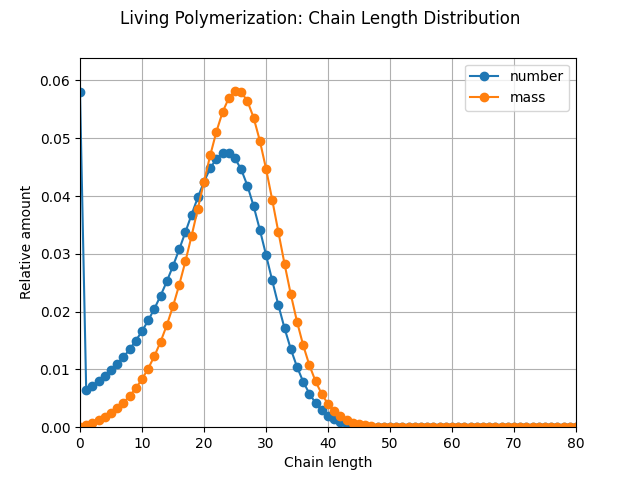

In [5]:
# Create the figure
fig, ax = plt.subplots()
fig.suptitle("Living Polymerization: Chain Length Distribution")
fig.canvas.header_visible = False

# Add empty lines (to be updated)
line_number, = ax.plot([], [], "o-", label="number")
line_mass, =  ax.plot([], [], "o-", label="mass")

ax.set_xlabel("Chain length")
ax.set_ylabel("Relative amount")
ax.legend(loc="upper right")
ax.grid(True)

def update_plot(v: float, r: float):
    """Update plot lines.

    Parameters
    ----------
    v : float
        Number-average chain length of full distribution.
    r : float
        Ratio kp/ki.
    """
    # Solution
    _, s, p = solve_distribution(v, r)
    
    # Final number CLD
    CLDn = p[:, -1]

    # Final mass CLD
    CLDm = s*CLDn
    CLDm /= CLDm.sum()

    # Update the plot
    line_number.set_data(s, CLDn)
    line_mass.set_data(s, CLDm)
    ax.set_xlim(s[0], s[-1])
    ax.set_ylim(0.0, 1.1*np.max((np.max(CLDn), np.max(CLDm))))
    fig.canvas.draw()


res = widgets.interact(update_plot,
                       v=widgets.FloatSlider(
                           value=20.0,
                           min=1.0,
                           max=100.0,
                           step=1.0,
                           continuous_update=True),
                       r=widgets.FloatLogSlider(
                           value=10.0,
                           min=-1.0,
                           max=2.0,
                           step=0.1,
                           continuous_update=True)
                       )

## 🔎 Questions

1. How does $r$ influence the shape of the CLD? 
1. Is there a qualitative difference between $r<1$ and $r>1$?
1. Is the effect of $r$ _qualitatively_ dependent or independent of $v$?
1. How does the polydispersity index evolve with increasing $v$?
   * Hint: use the CLD to compute the first three moments.